In this notebook, we will show how to combine all the four error suppression and mitigation methods, what is the flow for circuit transformations, and what is the sequence for data post-processing to get final mitigated results.

We will utilize the same circuit transformation and data post-processing blocks as described in earlier notebooks.

# Imports

In [1]:
# To make this notebook cleaner, we moved the ZNE and PT circuit transformation passes
# to a separate script and imported those pass managers in this notebook
from circuit_transformers import Local2qFolding, PauliTwirling

import mthree

import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeMumbai

from qiskit.circuit.library import XGate, RZGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.transpiler.passes import Optimize1qGatesDecomposition


from qiskit_ibm_provider import IBMProvider

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# Test Circuit

As the example circuit, we will use the same wormhole teleportation circuit from Lawrence Berkeley National Laboratory (LBNL) (https://arxiv.org/abs/2205.14081) as shown on the dynamical decoupling notebook.

In [2]:
g = Parameter('g')

In [3]:
qc = QuantumCircuit(6, 1)
qc.h(0)
qc.cx(0, 5)
qc.h(1)
qc.cx(1, 4)
qc.h(2)
qc.cx(2, 3)
qc.rx(-np.pi/2, 0)
qc.rx(-np.pi/2, 1)
qc.rx(-np.pi/2, 2)
qc.rz(-0.0566794, 0)
qc.rz(-0.01039906, 1)
qc.rz(-0.0632158, 2)
qc.rzz(-np.pi/2, 0, 1)
qc.rzz(-np.pi/2, 1, 2)
qc.rx(-np.pi/2, 0)
qc.rx(-np.pi/2, 1)
qc.rx(-np.pi/2, 2)
qc.rz(-0.0566794, 0)
qc.rz(-0.01039906, 1)
qc.rz(-0.0632158, 2)
qc.rzz(-np.pi/2, 0, 1)
qc.rzz(-np.pi/2, 1, 2)
qc.rx(-np.pi/2, 0)
qc.rx(-np.pi/2, 1)
qc.rx(-np.pi/2, 2)
qc.rz(-0.0566794, 0)
qc.rz(-0.01039906, 1)
qc.rz(-0.0632158, 2)
qc.rzz(-np.pi/2, 0, 1)
qc.rzz(-np.pi/2, 1, 2)
qc.reset(0)
qc.rz(0.0566794, 0)
qc.rz(0.01039906, 1)
qc.rz(0.0632158, 2)
qc.rzz(np.pi/2, 0, 1)
qc.rzz(np.pi/2, 1, 2)
qc.rx(np.pi/2, 0)
qc.rx(np.pi/2, 1)
qc.rx(np.pi/2, 2)
qc.rz(0.0566794, 0)
qc.rz(0.01039906, 1)
qc.rz(0.0632158, 2)
qc.rzz(np.pi/2, 0, 1)
qc.rzz(np.pi/2, 1, 2)
qc.rx(np.pi/2, 0)
qc.rx(np.pi/2, 1)
qc.rx(np.pi/2, 2)
qc.rz(0.0566794, 0)
qc.rz(0.01039906, 1)
qc.rz(0.0632158, 2)
qc.rzz(np.pi/2, 0, 1)
qc.rzz(np.pi/2, 1, 2)
qc.rx(np.pi/2, 0)
qc.rx(np.pi/2, 1)
qc.rx(np.pi/2, 2)
# Here are the two RZZ gates that are parameterized
qc.rzz(g, 1, 4)
qc.rzz(g, 2, 3)
# -------------------------------------------------
qc.rx(np.pi/2, 5)
qc.rx(np.pi/2, 4)
qc.rx(np.pi/2, 3)
qc.rz(0.0566794, 5)
qc.rz(0.01039906, 4)
qc.rz(0.0632158, 3)
qc.rzz(np.pi/2, 5, 4)
qc.rzz(np.pi/2, 4, 3)
qc.rx(np.pi/2, 5)
qc.rx(np.pi/2, 4)
qc.rx(np.pi/2, 3)
qc.rz(0.0566794, 5)
qc.rz(0.01039906, 4)
qc.rz(0.0632158, 3)
qc.rzz(np.pi/2, 5, 4)
qc.rzz(np.pi/2, 4, 3)
qc.rx(np.pi/2, 5)
qc.rx(np.pi/2, 4)
qc.rx(np.pi/2, 3)
qc.rz(0.0566794, 5)
qc.rz(0.01039906, 4)
qc.rz(0.0632158, 3)
qc.rzz(np.pi/2, 5, 4)
qc.rzz(np.pi/2, 4, 3)
qc.measure(5, 0)

In [4]:
operator = SparsePauliOp("Z")

# Setting up Backend and Noisy Simulator

In [5]:
provider = IBMProvider()
backend = provider.get_backend("ibm_peekskill")
simulator = AerSimulator.from_backend(backend)

In [6]:
runner = simulator

In [7]:
basis_gates = set(runner.configuration().basis_gates)
basis_gates

{'break_loop',
 'continue_loop',
 'cx',
 'delay',
 'for_loop',
 'id',
 'if_else',
 'kraus',
 'qerror_loc',
 'quantum_channel',
 'roerror',
 'rz',
 'save_amplitudes',
 'save_amplitudes_sq',
 'save_clifford',
 'save_density_matrix',
 'save_expval',
 'save_expval_var',
 'save_matrix_product_state',
 'save_probabilities',
 'save_probabilities_dict',
 'save_stabilizer',
 'save_state',
 'save_statevector',
 'save_statevector_dict',
 'save_superop',
 'save_unitary',
 'set_density_matrix',
 'set_matrix_product_state',
 'set_stabilizer',
 'set_statevector',
 'set_superop',
 'set_unitary',
 'superop',
 'sx',
 'while_loop',
 'x'}

In [8]:
two_q_gate_name = list(basis_gates.intersection({'cx', 'cz', 'ecr'}))[0]
print(f"Two Q gate name: {two_q_gate_name}")

Two Q gate name: cx


# Circuit Transformations

# 1st step: Transpilation

We always start the circuit transformation with transpilation. Otherwise, the subsequent steps may miss out many gates that are introduced by gate decomposition and routing to make a circuit device compatible. For example, the input circuit may contain 3q+ gates. If it is fed to a ZNE circuit transformer that finds and folds only 2q gates, then gate folding process will miss out gates. Also, routing stage in transpilation may add many 2q gates. If ZNE transformation is done pre-transpilation, it will miss out on many extra 2q gates from routing.

In [9]:
trans_qc = transpile(qc, backend=runner, optimization_level=3, seed_transpiler=0)

In [10]:
g_vals = np.linspace(0, np.pi, 11)
main_circuits = [trans_qc.assign_parameters([val]) for val in g_vals]

# 2nd step: Apply ZNE transformation

In [11]:
zne_circs = []
scale_factors = [1.0, 1.5, 2.0]
from qiskit.converters import circuit_to_dag
for circ in main_circuits:
    for factor in scale_factors:
        pm = PassManager([Local2qFolding(scale_factor=factor, folding_gate=two_q_gate_name)])
        zne_circs.append(pm.run(circ))

In [12]:
len(zne_circs)

33

In [13]:
print(
    f"{two_q_gate_name} counts: orig={zne_circs[0].count_ops()[two_q_gate_name]} | "
    f"{scale_factors[1]}x={zne_circs[1].count_ops()[two_q_gate_name]} | "
    f"{scale_factors[2]}x={zne_circs[2].count_ops()[two_q_gate_name]}"
)

cx counts: orig=30 | 1.5x=44 | 2.0x=60


# 3rd step: Apply PT transformation

PT transformation should be applied after ZNE transformation as ZNE transformation adds new 2q gates in the circuit due to gate folding for noise amplification purpose. If PT is done pre-ZNE, then it will miss out on twirling new 2q gates introduced by the ZNE stage.

In [14]:
pt_circs = []
num_twirls = 10
pm = PassManager([PauliTwirling(two_q_gate_name, seed=54321), 
                       Optimize1qGatesDecomposition(backend.target.operation_names)])
for circ in zne_circs:
    for _ in range(num_twirls):
        pt_circs.append(pm.run(circ))

In [15]:
len(pt_circs) # 11 * 3 * 10

330

# 4th step: Apply DD transformation

DD transformation must be applied after PT. After the PT stage is done adding new gates, the circuit will have the most accurate timing information of idle times between gates such that the DD pass can work upon it.

In [16]:
# simulator and fake-backends typically do not contain the timing constraints
# therefore, using real backend information to apply DD transformations
durations = InstructionDurations.from_backend(backend)
constraints = backend.configuration().timing_constraints
dd_sequence = [XGate(), XGate(),]
spacing = [1 / 4, 1 / 2, 1 / 4]
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence, spacing=spacing,
                                         pulse_alignment=constraints['pulse_alignment'])])
dd_circs = pm.run(pt_circs)

# 5th step: Configure M3 measurement mitigator

M3mitigator can be configured after the transpilation stage. It only needs the final virtual-to-physical qubit mappings. After transpilation stage, these mappings are set, and the subsequent stages do not alter that mapping (at least with local 2q gate folding variant of ZNE). However, in this example, we configure the M3mitigator after all circuit transformations are done, and it is the most safest route as after all stages of circuit transformations are done, the final qubit mappings can not change.

In [17]:
m3_mitigator = mthree.M3Mitigation(runner)
final_maps = mthree.utils.final_measurement_mapping(dd_circs)

# Executing Circuits

## Run measurement calibration

In [18]:
m3_mitigator.cals_from_system(final_maps)

## Run main circuits

IBM backends have a max circuits length of 300 circuits. Thus, we split our circuits in batches of 300 circuits at max.

In [19]:
max_circuits = 300
shots = 1500
raw_counts = []

for i in range(0, len(dd_circs), max_circuits):
    batch = dd_circs[i:i+max_circuits]
    counts = runner.run(batch, shots=shots).result().get_counts()
    raw_counts.extend(counts)

## Result Post-processing

For result post-processing, we follow the opposite order of circuit transformations.

### step 1: Apply measurement mitigation

Applying measurement mitigation using M3, converts the raw counts to quasi probability distributions.

In [20]:
quasi_probs = m3_mitigator.apply_correction(raw_counts, final_maps)

### step 2: aggregate probabilities of twirls

In [21]:
def aggregate_data(data, normalize=False):
    aggregated = {}

    total = len(data) if normalize else 1
    
    for dist in data:
        for key in dist:
            aggregated[key] = aggregated.get(key, 0) + (dist[key]/total)
            
    return aggregated

As after the application of measurement mitigation, the result is converted into quasi probability distributions, we aggregate the quasi probabilities across all the twirls using `normalize=True` as aggregated probability must be `1.0`.

In [22]:
aggregated_probs = []

for i in range(0, len(quasi_probs), num_twirls):
    probs_to_agg = quasi_probs[i:i+num_twirls]
    aggregated_probs.append(aggregate_data(data=probs_to_agg, normalize=True))

In [23]:
len(aggregated_probs)

33

#### Convert to expectation values

In [24]:
expvals = [sampled_expectation_value(dist=dist, oper=operator) for dist in aggregated_probs]

### step 3: apply extrapolation

In [25]:
def extrapolate(xvals, yvals, deg=1):
    return np.polyfit(x=xvals, y=yvals, deg=deg)[-1]

In [26]:
mitigated_expvals = []

xvals = scale_factors
num_scale_facs = len(xvals)
for i in range(0, len(expvals), num_scale_facs):
    yvals = expvals[i:i+num_scale_facs]
    mitigated_expvals.append(extrapolate(xvals, yvals))

In [27]:
len(mitigated_expvals)

11

## Ideal values for comparison

In [28]:
ideal_sim = AerSimulator()
ideal_counts = ideal_sim.run(main_circuits, shots=num_twirls*300).result().get_counts()
ideal_expvals = [sampled_expectation_value(dist=dist, oper=operator) for dist in ideal_counts]

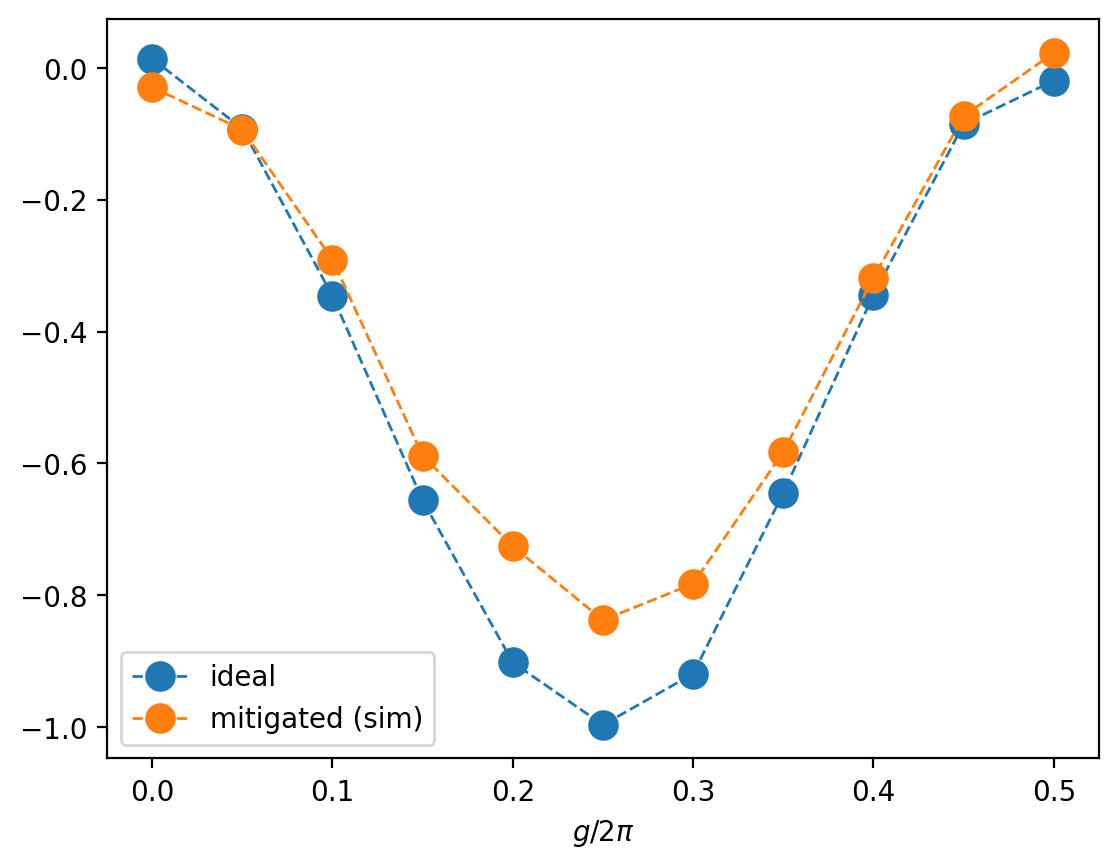

In [29]:
fig, ax = plt.subplots()
ax.plot(g_vals/(2*np.pi), ideal_expvals, 'o--', ms=10, lw=1, label='ideal')
ax.plot(g_vals/(2*np.pi), mitigated_expvals, 'o--', ms=10, lw=1, label='mitigated (sim)')
ax.legend()
ax.set_xlabel('$g/2\pi$');